In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
df.shape

(398, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [6]:
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [7]:
print(df.shape)
df = df[df['horsepower'] != '?']
print(df.shape)

(398, 9)
(392, 9)


In [8]:
df['horsepower'] = df['horsepower'].astype(int)
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [9]:
df.nunique()

mpg             127
cylinders         5
displacement     81
horsepower       93
weight          346
acceleration     95
model year       13
origin            3
car name        301
dtype: int64

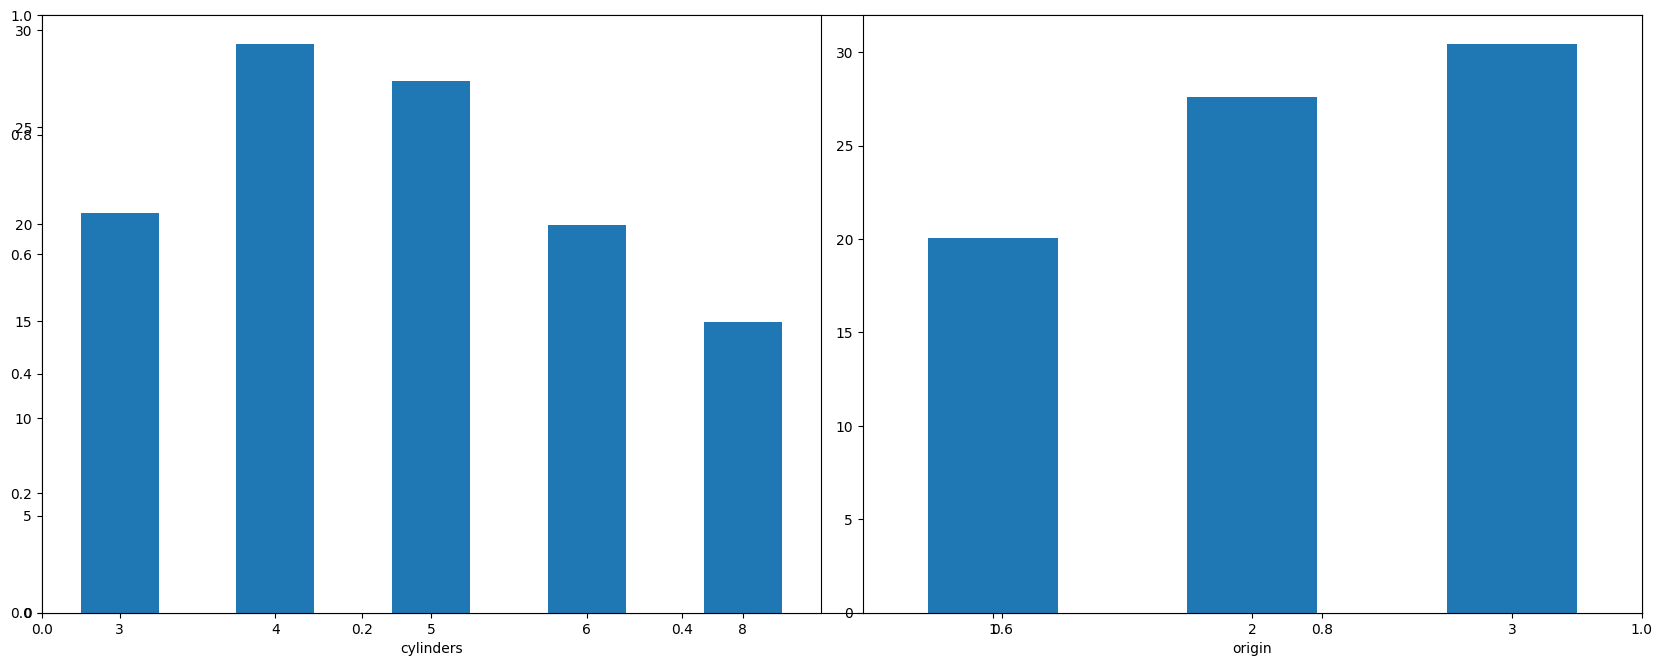

In [10]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.subplots(figsize=(17, 7))
for i, col in enumerate(['cylinders', 'origin']):
    plt.subplot(1, 2, i+1)
    x = numeric_df.groupby(col).mean()['mpg']
    x.plot.bar()
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

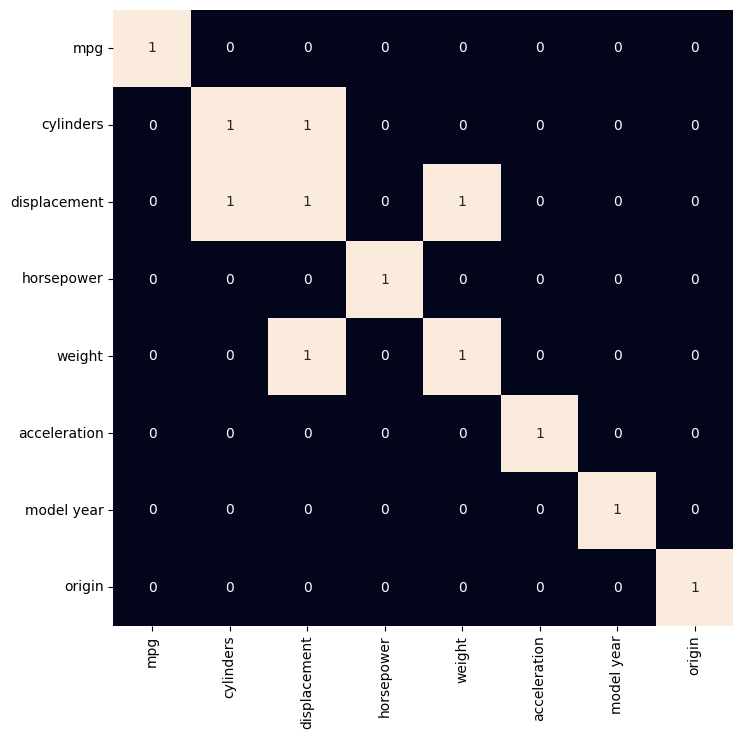

In [11]:
plt.figure(figsize=(8, 8)) 
sns.heatmap(numeric_df.corr()> 0.9, 
        annot=True, 
        cbar=False) 
plt.show()



In [12]:
df.drop('displacement',
		axis=1,
		inplace=True)

In [13]:
from sklearn.model_selection import train_test_split
features = df.drop(['mpg', 'car name'], axis=1)
target = df['mpg'].values

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
									test_size=0.2,
									random_state=22)
X_train.shape, X_val.shape

((313, 6), (79, 6))

In [14]:
# Data Input Pipeline

AUTO = tf.data.experimental.AUTOTUNE	# automatically tune the process

train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train)) # create a dataset
	.batch(32) # batch size no 32
	.prefetch(AUTO) # automatically tune prefetching
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.batch(32)
	.prefetch(AUTO)
)

# Batch size is no of data points passed through the model
# Model performs 32 samples at a time, then updates after each sample
# Eg data of 10k samples, then for one epoch model performs 10k/32=312 updatess

In [15]:
# Model Architecture
# Define a neural network using TensorFlow's Keras Sequential API

# Initialize the Sequential model
model = keras.Sequential([

    # First Dense layer with 256 neurons, ReLU activation, and input shape of 6 features
    layers.Dense(256, activation='relu', input_shape=[6]),  
    
    # Apply Batch Normalization, norma;ize inputs in each layer to stabilize training
    layers.BatchNormalization(),
    
    # Second Dense layer with 256 neurons and ReLU activation
    layers.Dense(256, activation='relu'),
    
    # Dropout layer, 30% of neurons are dropped set to 0 to prevent overfitting
    # Improve generalization on unseen data.
    layers.Dropout(0.3),
    
    # Apply another Batch Normalization after the second Dense layer
    layers.BatchNormalization(),
    
    # Output Dense layer with 1 neuron and ReLU activation
    # ReLU here ensures the output is non-negative
    layers.Dense(1, activation='relu')  
])


c:\Users\HP\Desktop\DataScience_Projects\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
	loss='mae',			# Mean Absolute Error is loss function used for training
	optimizer='adam',	# Adam optimizer for efficient gradient descent
	metrics=['mape']	# Mean Absolute Percentage Error as a metric to evaluate model accuracy
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,889 (273.00 KB)

 Trainable params: 68,865 (269.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

+ sequantial_4  
The 4th version of a sequential model used in this session  
+ dense layer fully connected layer  
Output, outputs layer with 256 neurons  
None means batch size is flexible, depends on input data  
`param=(input x units)+biases` (6×256)+256=1,792  
+ batch normalization  
(256x2)=512 for scaling+512 for shifting=1,024  
+ dense layer 2  
`param=(input x units)+biases` (256×256)+256=65,792  
+ dropout layer  
No parameters are learned in the dropout layer  
+ dense layer  
Only 1 output  
`param=(input x units)+biases` (256×1)+1=257  


In [18]:
# Model Training
history = model.fit(train_ds,
					epochs=50,              # how many times the model will go through the entire dataset
					validation_data=val_ds) # dataset to evaluate performance after each epoch

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - loss: 21.8657 - mape: 93.6712 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.7175 - mape: 82.8376 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1445 - mape: 77.4910 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.7707 - mape: 72.6681 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.4532 - mape: 68.0991 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.2818 - mape: 63.9830 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.2995 - mape: 60.4647 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4722 - mape: 57.5212 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 9/50
10/

+ loss  
Training loss, the error the model makes on the training data after each epoch  
Helps model adjust its weights to minimize the difference btwn predicted and actual values  
+ val_loss  
How well model acts on unseen data  
+ mape  
Mean Absolute %age Error btwn actual and predicted values  
+ val_mape  

In [19]:
history_df = pd.DataFrame(history.history)
history_df.head()

# history.history is a dictionary where the keys are the names of the metrics (e.g., 'loss', 'val_loss')
# history.history['loss'] has training loss values for each epoch

,loss,mape,val_loss,val_mape
0,21.001377,90.560028,22.418987,100.0
1,18.415136,81.625153,22.418987,100.0
2,16.922724,76.516548,22.418987,100.0
3,15.519065,71.473824,22.418987,100.0
4,14.281873,67.136147,22.418987,100.0


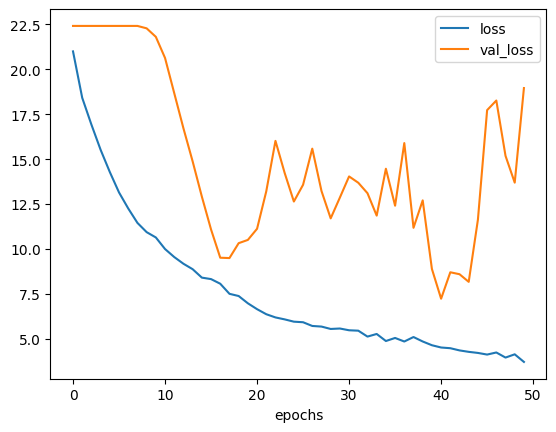

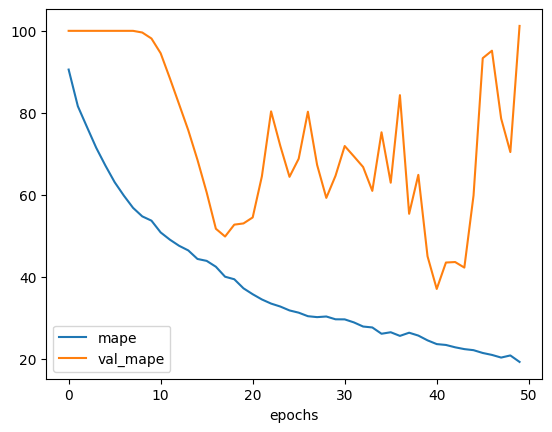

In [20]:
history_df.loc[:, ['loss', 'val_loss']].plot(xlabel='epochs') # all rows, loss and val_loss columns
history_df.loc[:, ['mape', 'val_mape']].plot(xlabel='epochs') # all rows, mape and val_mape columns
plt.show()